## importing data, merging, standarization

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import warnings

In [2]:
# Load the core stock dataset (contains 135,890 observations and 94 characteristics)
df = pd.read_parquet('chars_and_returns.parquet')
# Create the 'yyyymm' join key (Stock DATE is YYYYMMDD (int), we need YYYYMM to match the macro CSV)
df['date'] = df['DATE'].apply(lambda x: int(str(x)[:6]))
df = df.drop(columns=['DATE'])
df = df[['date'] + [col for col in df.columns if col != 'date']]

# Load the Macroeconomic predictors (Goyal-Welch)
macro = pd.read_csv('GoyalAndWelch2024.csv')
macro = macro.rename(columns={'yyyymm': 'date'})

print(f"Stock Data Shape: {df.shape}")
print(f"Macro Data Shape: {macro.shape}")

Stock Data Shape: (135890, 98)
Macro Data Shape: (1836, 57)


In [3]:
# Create excess returns dataframe
returns_df = (df[['permno', 'date', 'monthly_return']].sort_values(['permno', 'date']))
rf_df = macro[['date', 'Rfree']].sort_values('date').reset_index(drop=True)
returns_df = (returns_df.merge(rf_df, on='date', how='left', validate='many_to_one'))
returns_df['excess_return'] = returns_df['monthly_return'] - returns_df['Rfree']
df = df.drop(columns=['monthly_return'])

print(f"Excess Returns Data Shape: {len(returns_df)}")

Excess Returns Data Shape: 135890


In [4]:
# Standardization and shifting macro features

# This silences standard NumPy/Pandas runtime warnings like 'Mean of empty slice'
warnings.filterwarnings('ignore', category=RuntimeWarning)

char_cols = [c for c in df.columns if c not in ['permno', 'date', 'sic2']]
chars_df = df[['permno', 'date', 'sic2'] + char_cols].sort_values(['permno', 'date'])

# Fill missing characteristics with the median of other stocks that month
chars_df[char_cols] = chars_df.groupby('date')[char_cols].transform(lambda x: x.fillna(x.median()))
# Any remaining NaNs (if a whole month is missing a feature) fill with 0
chars_df[char_cols] = chars_df[char_cols].fillna(0)

# Memory-Efficient Ranking AND Range Shift [-1, 1]
print("Ranking characteristics into [-1, 1] interval (Memory-Safe Mode)...")
for col in char_cols:
    # rank(pct=True) gives [0, 1] -> (* 2) - 1 gives [-1, 1]
    chars_df[col] = chars_df.groupby('date')[col].transform(lambda x: (x.rank(pct=True) * 2) - 1)

print(f"Data Preparation Complete. Features are now centered at 0.")

# Define the exact 8 predictors from the paper
macro_cols = ['d/p', 'e/p', 'b/m', 'ntis', 'tbl', 'tms', 'dfy', 'svar']
macro_feat = (macro[['date'] + macro_cols].sort_values('date').reset_index(drop=True))

# Shift macro features by one month to avoid look-ahead bias
macro_feat[macro_cols] = macro_feat[macro_cols].shift(1)

Ranking characteristics into [-1, 1] interval (Memory-Safe Mode)...
Data Preparation Complete. Features are now centered at 0.


In [5]:
model_df = (
    returns_df[['permno', 'date', 'excess_return']]
    .merge(chars_df, on=['permno', 'date'], how='inner')
    .merge(macro_feat, on='date', how='inner')
    .dropna()
    .reset_index(drop=True)
)
print(f"Success! Merged 8 macro predictors into {len(model_df)} rows.")

Success! Merged 8 macro predictors into 134576 rows.


In [6]:
# Feature Creation

# Interaction Loop
interacted_list = []

# Creating the 'const' columns (i.e., no interaction)
print(f"Creating interactions...")
temp_const = model_df[char_cols].copy()
temp_const.columns = [f"{c}_const" for c in char_cols]
interacted_list.append(temp_const)

# Interaction with Macro Variables
for m_col in macro_cols:
    # We multiply and immediately convert to float32 to save 50% memory
    temp_inter = model_df[char_cols].multiply(model_df[m_col], axis=0).astype('float32')
    temp_inter.columns = [f"{c}_{m_col.replace('/', '')}" for c in char_cols]
    interacted_list.append(temp_inter)

# Final Concatenation
X_final = pd.concat(interacted_list, axis=1)
# Add industry dummies last
industry_dummies = pd.get_dummies(model_df['sic2'], prefix='sic').astype('int8')
X_final = pd.concat([X_final, industry_dummies], axis=1)

print(f"Success! Created {X_final.shape[1]-103} features.")

# Identify which columns are the 'Industry Dummies'
# These should NEVER be ranked
dummy_cols = [c for c in X_final.columns if c.startswith('sic_')]

# Identify the numerical columns (Base Chars + Interactions)
# Re-ranking the whole list is safer for the model's 'sanity'.
cols_to_rank = [c for c in X_final.columns if c not in dummy_cols]

print(f"Finalizing {len(cols_to_rank)} numerical features...")
for col in cols_to_rank:
    # This ensures everything is in the [-1, 1] range cross-sectionally
    X_final[col] = X_final.groupby(model_df['date'])[col].transform(
        lambda x: (x.rank(pct=True) * 2) - 1
    )

print("X_final is now perfectly stationary. Industry dummies (0/1) preserved.")
# might take 1-2 minutes depending on our hardware

Creating interactions...
Success! Created 803 features.
Finalizing 846 numerical features...
X_final is now perfectly stationary. Industry dummies (0/1) preserved.


In [7]:
# Seeing how many months we have and defining the splits

# Define the split lengths (in years)
validation_years = 12  # Gu et al. (2020) use 12 years
test_years_count = 6   # Predicting 2016, 2017, 2018, 2019, 2020, 2021

# Calculate the counts
total_months = model_df['date'].nunique() # Total months available in our data
test_months = test_years_count * 12
val_months = validation_years * 12
initial_train_months = total_months - val_months - test_months

print(f"--- KELLY REPLICATION DATA AUDIT ---")
print(f"Total Period: {total_months} months ({total_months/12:.1f} years)")
print(f"1. Initial Training Set: {initial_train_months} months (1962 - {1962 + (initial_train_months//12)})")
print(f"2. Validation Set:       {val_months} months (Last 12 years before test)")
print(f"3. Out-of-Sample Test:   {test_months} months (2016 - 2021)")
print("-" * 60)
print(f"Note: In each annual refit, the Training Set will grow by 12 months.")

--- KELLY REPLICATION DATA AUDIT ---
Total Period: 719 months (59.9 years)
1. Initial Training Set: 503 months (1962 - 2003)
2. Validation Set:       144 months (Last 12 years before test)
3. Out-of-Sample Test:   72 months (2016 - 2021)
------------------------------------------------------------
Note: In each annual refit, the Training Set will grow by 12 months.


In [8]:
# Doing the actual spliting based on expanding windows

# Convert date to integer if it's not already, to ensure comparisons work
model_df['date'] = model_df['date'].astype(int)

# Define our target years for the Out-of-Sample test
test_years = [2016, 2017, 2018, 2019, 2020, 2021]

# Initialize a dictionary to hold our yearly results
yearly_splits = {}

print("--- GENERATING ANNUAL EXPANDING WINDOWS ---")

for year in test_years:
    # Test period: The full current year
    test_start = year * 100 + 1     # e.g., 201601
    test_end = year * 100 + 12      # e.g., 201612
    
    # Validation period: The 12 years immediately preceding the test year
    val_start = (year - 12) * 100 + 1
    val_end = (year - 1) * 100 + 12
    
    # Training period: From the start of data up to the start of validation
    train_start = model_df['date'].min()
    train_end = (year - 13) * 100 + 12
    
    # Create masks
    train_idx = model_df[(model_df['date'] >= train_start) & (model_df['date'] <= train_end)].index
    val_idx = model_df[(model_df['date'] >= val_start) & (model_df['date'] <= val_end)].index
    test_idx = model_df[(model_df['date'] >= test_start) & (model_df['date'] <= test_end)].index
    
    print(f"Year {year}: Train Months: {model_df.loc[train_idx, 'date'].nunique()} | "
          f"Val Months: {model_df.loc[val_idx, 'date'].nunique()} | "
          f"Test Months: {model_df.loc[test_idx, 'date'].nunique()}")
    
    # Store indices for training
    yearly_splits[year] = {
        'train': train_idx,
        'val': val_idx,
        'test': test_idx
    }

print("\n All splits defined. Ready for Model Training.")

--- GENERATING ANNUAL EXPANDING WINDOWS ---
Year 2016: Train Months: 503 | Val Months: 144 | Test Months: 12
Year 2017: Train Months: 515 | Val Months: 144 | Test Months: 12
Year 2018: Train Months: 527 | Val Months: 144 | Test Months: 12
Year 2019: Train Months: 539 | Val Months: 144 | Test Months: 12
Year 2020: Train Months: 551 | Val Months: 144 | Test Months: 12
Year 2021: Train Months: 563 | Val Months: 144 | Test Months: 12

 All splits defined. Ready for Model Training.


## Model Training

--- STARTING FIRST TRAINING WITH 906 FEATURES ---
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[130]	train's rmse: 0.0951952	valid's rmse: 0.0890586
Training complete. The learning curves are as follows:


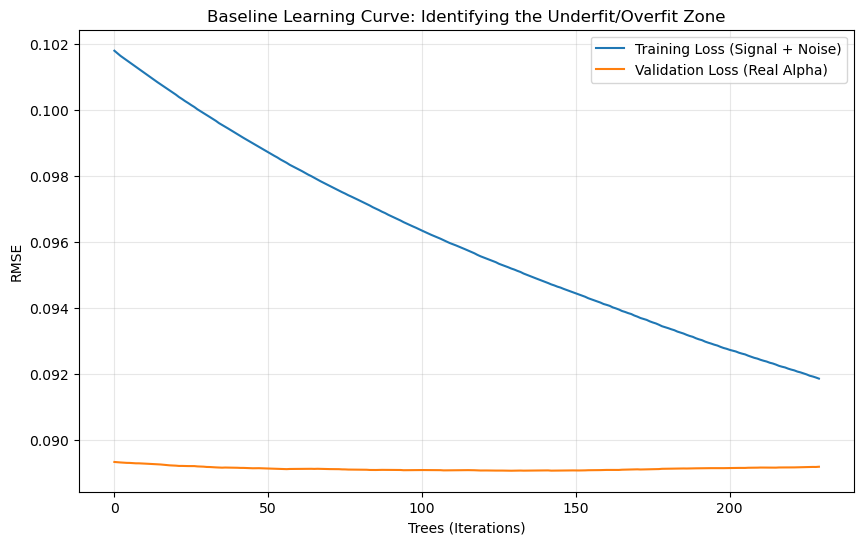

Feature Importance Analysis:
Top 10 Economically Significant Features:
           feature        gain
31      divi_const  845.667910
32      divo_const  486.776896
59        rd_const  483.992758
70       sin_const  393.635266
125        divi_dp  367.347226
407      divi_ntis  352.887263
446       sin_ntis  328.947657
408      divo_ntis  289.153758
28   convind_const  269.025000
153          rd_dp  211.418500

Features with ZERO contribution: 263 out of 906


In [9]:
# ---  TRAINING LOOP ---

indices = yearly_splits[2020]

print(f"--- STARTING FIRST TRAINING WITH {X_final.shape[1]} FEATURES ---")

# We use moderate leaves and high L2 to force a smooth curve
baseline_params = {
    'objective': 'regression',
    'metric': 'rmse',
    'learning_rate': 0.005,
    'num_leaves': 255,
    'min_child_samples': 50,
    'lambda_l2': 50.0,
    'lambda_l1': 0.1,
    'feature_fraction': 0.6,   # Look at 60% of features per tree
    # 'max_bin': 255,
    'verbosity': -1,
    'seed': 42
}

# Prepare Datasets
dtrain = lgb.Dataset(X_final.loc[indices['train']], label=model_df.loc[indices['train'], 'excess_return'])
dval = lgb.Dataset(X_final.loc[indices['val']], label=model_df.loc[indices['val'], 'excess_return'])

# Train with Evaluation Record
evals_result = {}
model = lgb.train(
    baseline_params,
    dtrain,
    num_boost_round=500,
    valid_sets=[dtrain, dval],
    valid_names=['train', 'valid'],
    callbacks=[
        lgb.record_evaluation(evals_result),
        lgb.early_stopping(stopping_rounds=100)
    ]
)

print("Training complete. The learning curves are as follows:")

plt.figure(figsize=(10, 6))
plt.plot(evals_result['train']['rmse'], label='Training Loss (Signal + Noise)')
plt.plot(evals_result['valid']['rmse'], label='Validation Loss (Real Alpha)')
plt.title('Baseline Learning Curve: Identifying the Underfit/Overfit Zone')
plt.xlabel('Trees (Iterations)')
plt.ylabel('RMSE')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print("Feature Importance Analysis:")
# Get feature importance
importance = pd.DataFrame({
    'feature': X_final.columns,
    'gain': model.feature_importance(importance_type='gain')
}).sort_values('gain', ascending=False)

print("Top 10 Economically Significant Features:")
print(importance.head(10))

# Check for Zero-Gain features
zero_gain = importance[importance['gain'] == 0]
print(f"\nFeatures with ZERO contribution: {len(zero_gain)} out of {len(importance)}")

This is very common in stock prediction. Most of a stock's move is "unpredictable noise." The fact that we are lowering the error at all means we are finding a real, albeit small, alpha signal.

In [10]:
# GENERATE FINAL PREDICTIONS
# We pull the stock IDs (permno/date) and the actual target to align with our prediction
final_preds_2021 = model_df.loc[indices['test'], ['permno', 'date', 'excess_return']].copy()
final_preds_2021['prediction'] = model.predict(X_final.loc[indices['test']])

print(f"Final 2021 Predictions ready: {len(final_preds_2021)} rows.")

Final 2021 Predictions ready: 5296 rows.


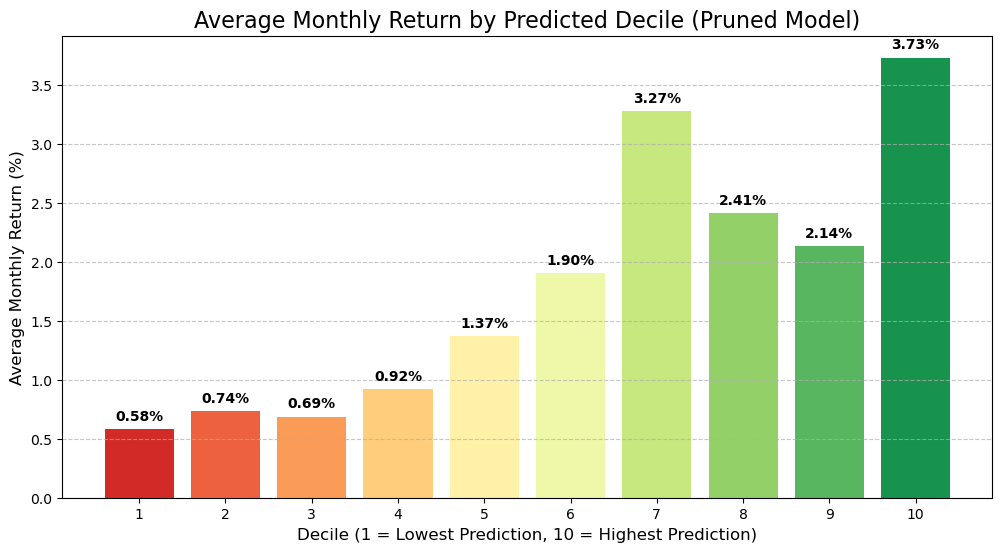

--- PORTFOLIO PERFORMANCE SUMMARY ---
Monthly Long-Short Spread: 3.15%
Annualized Spread: 37.76%

--- STRATEGY RISK AUDIT ---
Monthly Mean Return:  3.25%
Monthly Volatility:   5.49%
SHARPE ratio:         0.59
Annualized SHARPE:    2.05


In [11]:
# Decile Spread Chart

# Rank predictions within each month to create Deciles
# This ensures we are comparing stocks against their peers at the same point in time
final_preds_2021['decile'] = final_preds_2021.groupby('date')['prediction'].rank(method='first')
final_preds_2021['decile'] = final_preds_2021.groupby('date')['decile'].transform(
    lambda x: pd.qcut(x, 10, labels=False) + 1
)

# Calculate average monthly ACTUAL return for each predicted Decile
decile_analysis = final_preds_2021.groupby('decile')['excess_return'].mean()

# Calculate the Long-Short Spread (Decile 10 - Decile 1)
ls_spread = decile_analysis.loc[10] - decile_analysis.loc[1]

# Plot the "Staircase"
plt.figure(figsize=(12, 6))
colors = sns.color_palette("RdYlGn", 10) # Red for Decile 1, Green for Decile 10
bars = plt.bar(decile_analysis.index, decile_analysis.values * 100, color=colors)

plt.title('Average Monthly Return by Predicted Decile (Pruned Model)', fontsize=16)
plt.xlabel('Decile (1 = Lowest Prediction, 10 = Highest Prediction)', fontsize=12)
plt.ylabel('Average Monthly Return (%)', fontsize=12)
plt.xticks(range(1, 11))
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add value labels on top of bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.05, f'{yval:.2f}%', ha='center', va='bottom', fontweight='bold')

plt.show()

print(f"--- PORTFOLIO PERFORMANCE SUMMARY ---")
print(f"Monthly Long-Short Spread: {ls_spread*100:.2f}%")
print(f"Annualized Spread: {ls_spread * 12 * 100:.2f}%")

# Long-Short Strategy

# Calculate the monthly Long-Short returns (Decile 10 - Decile 1)
strategy_returns = final_preds_2021[final_preds_2021['decile']==10].groupby('date')['excess_return'].mean() - \
                   final_preds_2021[final_preds_2021['decile']==1].groupby('date')['excess_return'].mean()

# Calculate the Sharpe Ratio (Annualized)
mean_ret = strategy_returns.mean()
std_dev = strategy_returns.std()
sharpe = (mean_ret / std_dev)
sharpe_annual = (mean_ret / std_dev) * (12**0.5)

print(f"\n--- STRATEGY RISK AUDIT ---")
print(f"Monthly Mean Return:  {mean_ret*100:.2f}%")
print(f"Monthly Volatility:   {std_dev*100:.2f}%")
print(f"SHARPE ratio:         {sharpe:.2f}")
print(f"Annualized SHARPE:    {sharpe_annual:.2f}")

In [ ]:
# Building the full backtest dataframe for all years

# FIX: Convert masks to YYYYMM to match your model_df['date']
yearly_splits = {}
test_years = [2016, 2017, 2018, 2019, 2020, 2021]

for year in test_years:
    # Use YYYYMM format (e.g., 201601 to 201612)
    test_start, test_end = year * 100 + 1, year * 100 + 12
    val_start, val_end = (year - 12) * 100 + 1, (year - 1) * 100 + 12
    train_end = (year - 13) * 100 + 12
    
    yearly_splits[year] = {
        'train': model_df[model_df['date'] <= train_end].index,
        'val':   model_df[(model_df['date'] >= val_start) & (model_df['date'] <= val_end)].index,
        'test':  model_df[(model_df['date'] >= test_start) & (model_df['date'] <= test_end)].index
    }
    
    # Audit print to ensure NO MORE ZEROS
    print(f"Year {year}: Train={len(yearly_splits[year]['train'])}, "
          f"Val={len(yearly_splits[year]['val'])}, Test={len(yearly_splits[year]['test'])}")

print("\n--- STARTING FULL BACKTEST PREDICTION LOOP ---")

all_preds_list = []

for year in test_years:
    idx = yearly_splits[year]
    
    # Safety Check: Skip if any data is missing for this year
    if len(idx['train']) == 0 or len(idx['val']) == 0:
        continue
        
    print(f"Predicting {year}...")
    
    # Prepare datasets
    dtrain = lgb.Dataset(X_final.loc[idx['train']], label=model_df.loc[idx['train'], 'excess_return'])
    dval   = lgb.Dataset(X_final.loc[idx['val']],   label=model_df.loc[idx['val'], 'excess_return'])
    
    # Train
    model = lgb.train(baseline_params, dtrain, valid_sets=[dval], 
                      callbacks=[lgb.early_stopping(100, verbose=False)])
    
    # Predict and Sync
    res = model_df.loc[idx['test'], ['permno', 'date', 'excess_return']].copy()
    res['prediction'] = model.predict(X_final.loc[idx['test']])
    
    # Calculate Deciles cross-sectionally by month
    res['decile'] = res.groupby('date')['prediction'].transform(
        lambda x: pd.qcut(x, 10, labels=False, duplicates='drop') + 1
    )
    
    all_preds_list.append(res)

final_backtest_df = pd.concat(all_preds_list)
print("Success! Data is ready for the Decile Plot.")

# might take 2-3 minutes depending on our hardware.

Year 2016: Train=52655, Val=50465, Test=4958
Year 2017: Train=56398, Val=51680, Test=5164
Year 2018: Train=60231, Val=53011, Test=5348
Year 2019: Train=64176, Val=54414, Test=5356
Year 2020: Train=68241, Val=55705, Test=5296
Year 2021: Train=72327, Val=56915, Test=5334

--- STARTING FULL BACKTEST PREDICTION LOOP ---
Predicting 2016...
Predicting 2017...
Predicting 2018...
Predicting 2019...
Predicting 2020...
Predicting 2021...
Success! Data is ready for the Decile Plot.


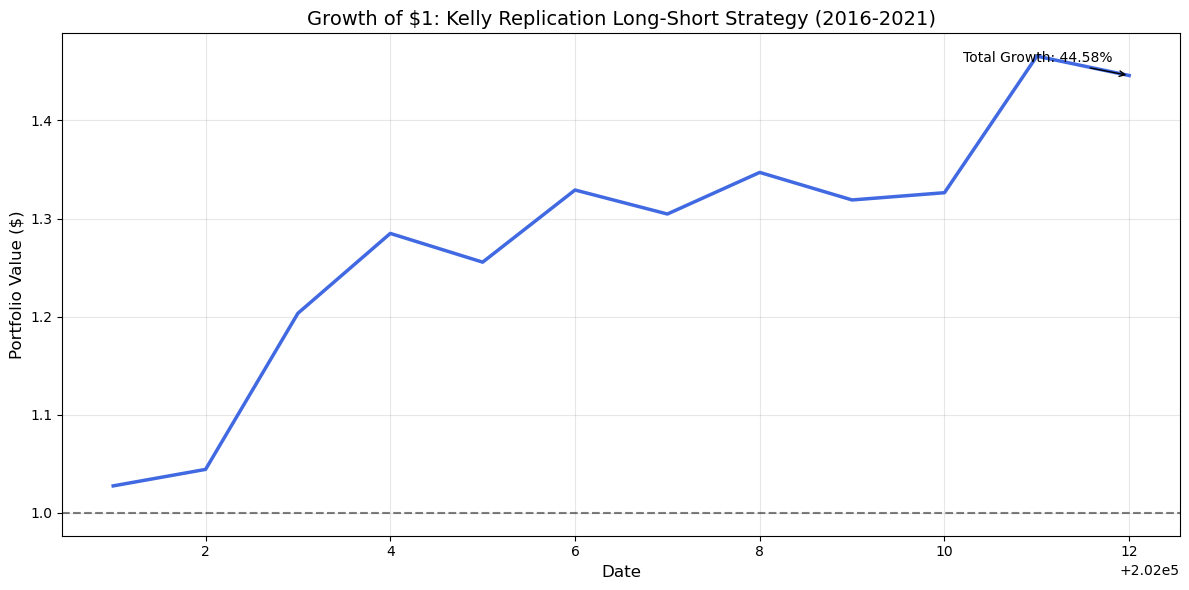

--- FINAL STRATEGY STATS ---
Total Cumulative Return:   44.58%
Maximum Drawdown:          -2.28%


In [13]:
# Calculate cumulative returns (compounding monthly)
# We use the 'strategy_returns' we calculated earlier
cumulative_growth = (1 + strategy_returns).cumprod()

# Plotting the results
plt.figure(figsize=(12, 6))
cumulative_growth.plot(color='royalblue', linewidth=2.5)

plt.title('Growth of $1: Kelly Replication Long-Short Strategy (2016-2021)', fontsize=14)
plt.ylabel('Portfolio Value ($)', fontsize=12)
plt.xlabel('Date', fontsize=12)
plt.grid(True, alpha=0.3)
plt.axhline(1, color='black', linestyle='--', alpha=0.5) # Baseline

# Add a highlight for the total return
total_return = (cumulative_growth.iloc[-1] - 1) * 100
plt.annotate(f'Total Growth: {total_return:.2f}%', 
             xy=(cumulative_growth.index[-1], cumulative_growth.iloc[-1]),
             xytext=(-120, 10), textcoords='offset points',
             arrowprops=dict(arrowstyle='->', color='black'))

plt.tight_layout()
plt.show()

# Calculate Maximum Drawdown
rolling_max = cumulative_growth.cummax()
drawdown = (cumulative_growth - rolling_max) / rolling_max
max_drawdown = drawdown.min()

print(f"--- FINAL STRATEGY STATS ---")
print(f"Total Cumulative Return:   {total_return:.2f}%")
print(f"Maximum Drawdown:          {max_drawdown*100:.2f}%")